In [1]:
import xgboost
from catboost import CatBoostClassifier
import shap

import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt

In [2]:
raw_data = ascii.read('../data/raw/plti/kplr_dr25_inj1_plti.txt')
df = raw_data.to_pandas()
df.dropna()


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'Fit_Provenance' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


KIC_ID  Sky_Group  i_period   i_epoch  N_Transit   i_depth  \
5       11601794          8   71.3789  111.5236    15.1325     838.0   
24      11752906          8   70.8269   67.1199    15.3007    1482.0   
32      11852982          8   21.6441   85.7861    50.6752     327.0   
33      11853130          8   70.9432  101.2425    16.1289    1588.0   
34      11854219          8   31.3363   96.2654    34.3284     793.0   
49      12005016          8   24.4795   88.3795    44.1366     769.0   
53      12102169          8   36.9909   74.6180    29.1442     675.0   
59       6579884         31   14.5834   76.6400    97.8850     618.0   
60       6580019         31   63.3769   66.9085     6.0810   67281.0   
63       6665209         31   71.6247   97.1001     4.9041  230091.0   
67       6750866         31    6.1696   65.7135   229.5100     436.0   
71       6751520         31   55.1121   97.4268    26.1550     960.0   
72       6751891         31   43.0795   98.8272    33.8380     853.0   
75       6836884         31   60.9302   78.0141    24.0844     862.0   
78       6838434         31   90.8780  127.5059    15.8892    5941.0   
79       6839317         31   39.6108   93.6450    34.4685     902.0   
81       6921821         31   78.3158  113.4488    17.8181     628.0   
97       7093688         31   55.4875  112.6586    23.2592    1343.0   
99       7173783         31   61.9578   71.5911    16.3470    1269.0   
104      7337164         31   31.1268   86.2785    47.2191     545.0   
108      7338033         31   76.3878  114.3366    17.9816     651.0   
110      7417813         31   35.1681   66.9946    39.4287     323.0   
118      7584332         31   88.0413   82.3703    16.4777     364.0   
119      5596422         52   35.0783   83.7653    32.5626     780.0   
120      5597604         52   53.9132   98.1347    21.5777     128.0   
137      5938531         52   58.6674  119.5976    19.2237    1212.0   
140      5939661         52   67.9533   83.9772    16.8138    1197.0   
141      5940100         52   62.3735   77.4069    16.6735    1379.0   
142      6019923         52   56.0675  106.5822    18.7987     600.0   
144      6020256         52   21.1893   72.9141    52.7671    1236.0   
...          ...        ...       ...       ...        ...       ...   
146217  10346880         39  439.2123  315.1889     3.0078     720.0   
146220  10346936         39   13.7589   73.3287   102.0045     175.0   
146222  10346988         39  377.7195  268.0348     4.0048    1005.0   
146227  10347115         39  273.7081  228.1685     4.9508     706.0   
146231  10347213         39   79.4097  111.6858    16.8046     387.0   
146232  10347260         39  326.0173  123.6875     3.9232    1098.0   
146234  10347285         39  106.8832   83.0620    12.9141     529.0   
146235  10347308         39    2.8693   65.1767   493.7410      74.0   
146238  10347415         39  332.4685  379.0216     4.0212     175.0   
146241  10347456         39  377.9079  103.9519     2.9834     392.0   
146244  10347577         39  483.0674  497.9397     3.0601    1140.0   
146245  10347624         39  478.5805  268.6888     2.9817     597.0   
146246  10347630         39  174.9352  107.4861     6.9202     562.0   
146247  10411287         39  148.6675  114.2382     9.0140     184.0   
146250  10411437         39   32.5476   69.4990    41.0540     492.0   
146252  10411459         39  260.6120  268.5701     2.9970     821.0   
146255  10411602         39  405.0670  214.2041     4.0017    1127.0   
146257  10411616         39    3.3243   68.2581   425.8362      25.0   
146258  10411647         39  189.9742  110.4788     6.9883     624.0   
146260  10411698         39   12.4320   70.6149   115.0821     239.0   
146263  10411779         39  425.7338  409.0136     3.0210     477.0   
146268  10411888         39   13.5095   77.0047   106.0367     301.0   
146271  10412014         39  221.4920  162.5652     7.0619     616.0   
146276  10412054         39  462.8473  208.0483   

In [120]:


def getFeatures(data, isSample):
    if isSample:
        sample = df.sample(n=5000, random_state=1)
        feat = ['i_period', 'i_epoch', 'N_Transit', 'i_depth', 'i_dur', 'i_b', 'i_ror', 'i_dor']

        sampledFeatures = sample[feat]

        recoverdMatrix = sample[['Recovered']].as_matrix()
        sampleRecovered = np.squeeze(np.asarray(recoverdMatrix))

        return sampledFeatures, sampleRecovered
    else:
        
        feat = ['i_period', 'i_epoch', 'N_Transit', 'i_depth', 'i_dur', 'i_b', 'i_ror', 'i_dor']
        features = data[feat].to_pandas()

        recoveredMatrix = data[['Recovered']].to_pandas().as_matrix()
        recovered = np.squeeze(np.asarray(recoveredMatrix))

        return features, recovered

originalX, originalY = getFeatures(raw_data, True)

originalX.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


i_period   i_epoch  N_Transit  i_depth     i_dur     i_b   i_ror  \
86747   107.5198   94.6133    13.0307    288.0   3.47757  0.8947  0.0159   
117971  281.9941  227.5575     4.9975    382.0  10.70103  0.4080  0.0172   
70373   482.5296  367.0859     3.0209   1503.0  12.69283  0.0916  0.0328   
44497   302.8754  274.6660     5.0349    402.0   7.79244  0.7794  0.0190   
50658   173.6540  160.2376     1.9616    519.0   5.61376  0.8799  0.0201   

          i_dor  
86747   114.979  
117971  187.751  
70373   299.396  
44497   195.492  
50658   123.944

In [121]:
X, X_test, y, y_test = train_test_split(originalX, originalY, train_size=0.90, random_state=42)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [122]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85, random_state=42)

In [124]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [125]:
model = CatBoostClassifier(
    n_estimators=1000,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [126]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [127]:
shap.initjs()

explainer = shap.TreeExplainer(model=model, feature_dependence='tree_path_dependent', model_output='margin')

In [128]:
shap_values = explainer.shap_values(X=originalX)

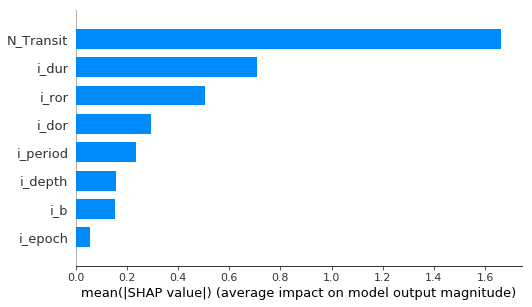

In [129]:
shap.summary_plot(shap_values, originalX, plot_type="bar")

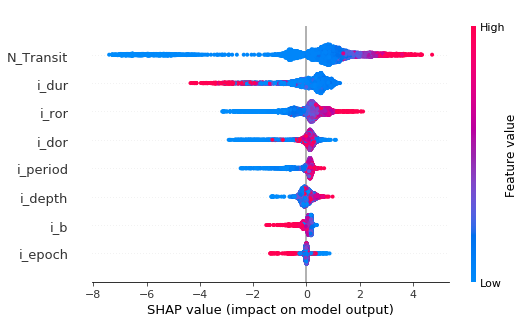

In [130]:
shap.summary_plot(shap_values, originalX)

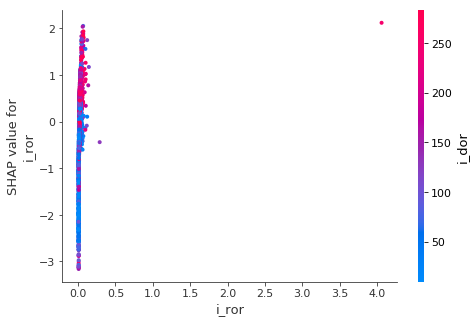

In [131]:
shap.dependence_plot(ind='i_ror', shap_values=shap_values, features=originalX)

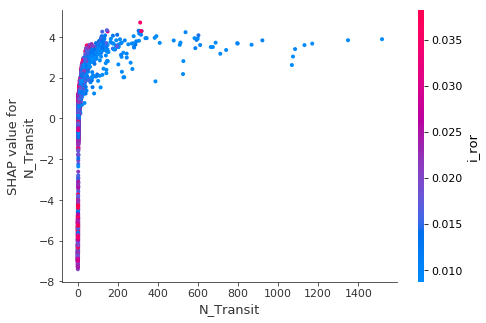

In [132]:
shap.dependence_plot(ind='N_Transit', shap_values=shap_values, features=originalX)

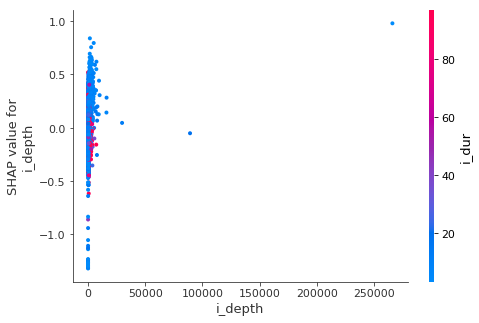

In [133]:
shap.dependence_plot(ind='i_depth', shap_values=shap_values, features=originalX)

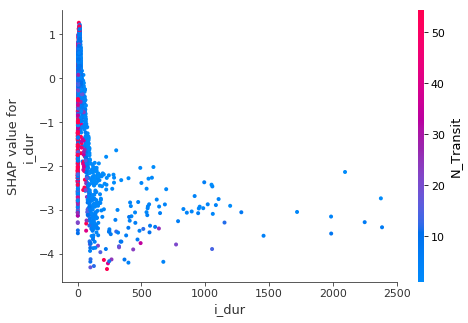

In [134]:
shap.dependence_plot(ind='i_dur', shap_values=shap_values, features=originalX)

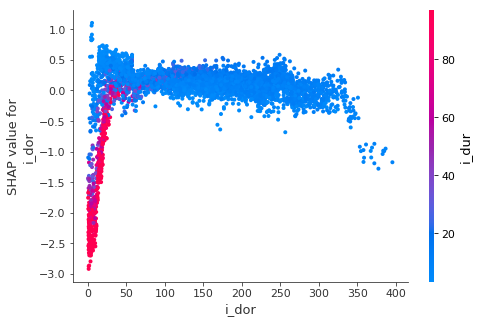

In [135]:
shap.dependence_plot(ind='i_dor', shap_values=shap_values, features=originalX)

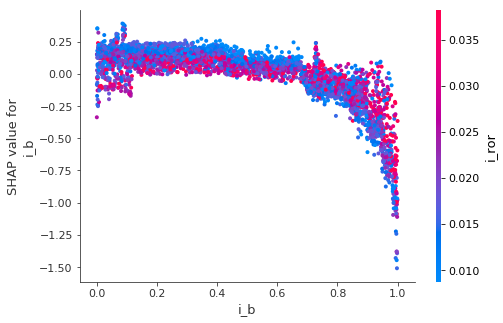

In [136]:
shap.dependence_plot(ind='i_b', shap_values=shap_values, features=originalX)

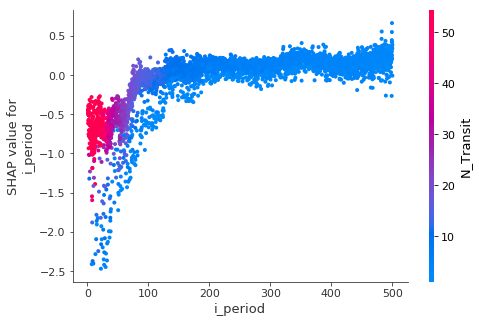

In [137]:
shap.dependence_plot(ind='i_period', shap_values=shap_values, features=originalX)

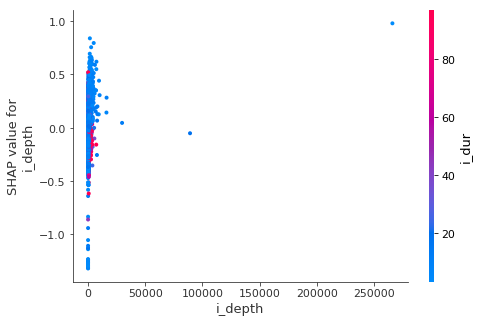

In [138]:
shap.dependence_plot(ind='i_depth', shap_values=shap_values, features=originalX)

In [139]:

shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=originalX)

/usr/local/lib/python3.7/site-packages/shap/plots/force.py:111: UserWarning: shap.force_plot is slow many thousands of rows, try subsampling your data.
  warnings.warn("shap.force_plot is slow many thousands of rows, try subsampling your data.")
